# Mean reversion
By Evgenia "Jenny" Nitishinskaya and Delaney Granizo-Mackenzie

Notebook released under the Creative Commons Attribution 4.0 License.

---

Mean-reversion strategies are those relying on the assumption that a variable deviating far from its observed mean will tend to reverse direction and revert to the mean. We expect it to go down if it is unusually high, and go up if it is unusually low. Why would this be the case? One explanation is that the deviations we are observing are random fluctuations, which are 0 in expectation. In this notebook, we will just focus on how to build strategies that take advantage of mean reversion when it is observed.

# Single-stock mean reversion

Mean reversion in the context of a stock price implies that periods of the price being far below the mean are followed by periods of the price going up, and vice versa. We can take advantage of this by buying long when the price is lower than expected, and selling short when the price is higher than expected. We can plot the price of a stock along with the mean of the prices up to each day to see whether the price reverts to the mean.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
from statsmodels.tsa.stattools import coint

In [2]:
# Define the get_pricing function using yfinance
def get_pricing(tickers, fields='price', start_date='2012-01-01', end_date='2015-01-01'):
    """
    Fetches historical pricing data for given tickers.

    Parameters:
    - tickers (str or list of str): Stock ticker symbols.
    - fields (str): Data field to retrieve ('price' supported).
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - pd.Series or pd.DataFrame: Adjusted Close prices.
    """
    data = yf.download(tickers, start=start_date, end=end_date, progress=False)
    if fields == 'price':
        if isinstance(tickers, list) or isinstance(tickers, tuple):
            return data['Adj Close']
        else:
            return data['Adj Close'].squeeze()
    else:
        raise ValueError("Unsupported field")

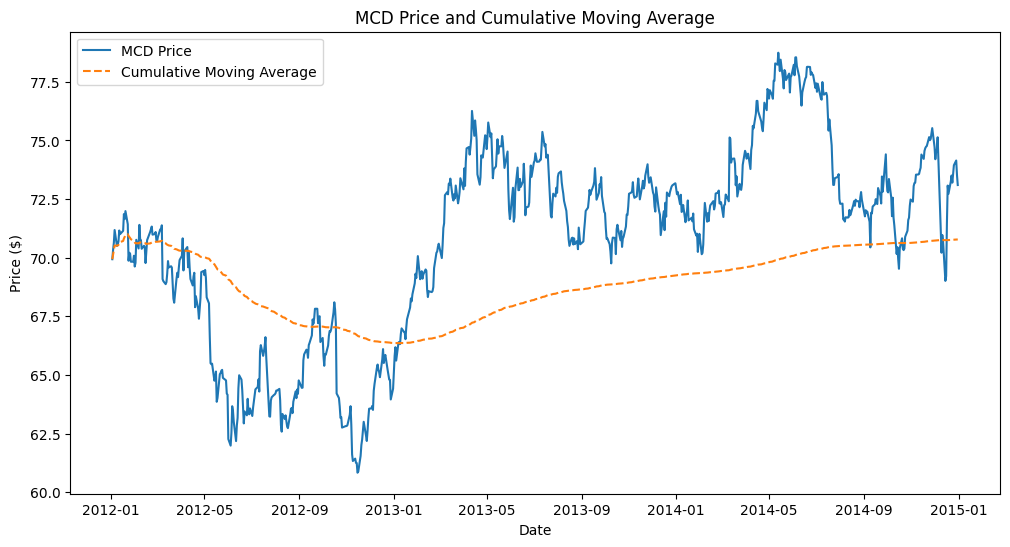

In [3]:
# Define the time period
start = '2012-01-01'
end = '2015-01-01'

# Load the pricing data for a single stock (e.g., McDonald's - MCD)
pricing = get_pricing('MCD', fields='price', start_date=start, end_date=end)


#TODO: Compute the cumulative moving average of the price
mu = 
raise NotImplementedError("This function needs to be implemented. Please modify the code.")

# Plot the price and the moving average
plt.figure(figsize=(12, 6))
plt.plot(pricing, label='MCD Price')
plt.plot(mu, label='Cumulative Moving Average', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.title('MCD Price and Cumulative Moving Average')
plt.legend()
plt.show()


Note that since we are computing the running average, "reverting to the mean" does not necessarily mean going as high or as low as it did before.

In order to trade using this strategy, we need to quantify what it means for the price to be higher or lower than expected. It's useful to compute the z-score of the price on each day, which tells us how many standard deviations away from the mean a value is:
$$ z = \frac{x - \mu}{\sigma} $$

where $x$ is the value, $\mu$ is the mean of the data set, and $\sigma$ is its standard deviation. So a price with a z-score $> 1$ is more than one standard deviation above the mean, and we will sell short when this happens. If the price on a day has a z-score $< 1$, we will buy long. If the price is within half a standard deviation of the mean, we will clear all positions.

In [4]:
# TODO: Compute the z-scores for each day using the historical data up to that day
zscores =
raise NotImplementedError("This function needs to be implemented. Please modify the code.")

# Initialize money and position count
money = 0
count = 0

# Iterate through each day to simulate trading
for i in range(len(pricing)):
    
    # TODO: Sell short if the z-score is > 1
    if zscores.iloc[i] > 1:
        raise NotImplementedError("This function needs to be implemented. Please modify the code.")
        
    # Buy long if the z-score is < -1
    elif zscores.iloc[i] < -1:
        raise NotImplementedError("This function needs to be implemented. Please modify the code.")

    # Clear positions if the z-score is between -0.5 and 0.5
    elif abs(zscores.iloc[i]) < 0.5:
        money += count * pricing.iloc[i]
        count = 0

print(f"Final Money: ${money:.2f}")


Final Money: $1002.32


The danger of applying mean reversion to a single stock is that it exposes us to the movement of the market and the success or failure of the individual company, among other factors. If there is a persistent trend affecting the price of the security, we will find ourselves consitently undervaluing (if the price is moving steadily upward) or overvaluing (if the price is falling) the asset. Below we discuss two strategies that mitigate this risk.

# Mean reversion portfolio

Instead of taking the mean of the historical returns on an asset, we can look at the mean of the returns on all of the stocks in, say, the S&P 500. Hypothesizing that the worst-performing stocks last period will do better this period (that is, they are likely to be undervalued) and vice versa, we go long in stocks that performed poorly and short in stocks that performed well.

This approach has the advantage of being market-neutral, so that we do not treat stocks as undervalued just because the market as a whole is falling, or overvalued when the market is rising. Furthermore, by including a large number of securities in portfolio, we are likely to encounter many cases where our prediction is correct.

To construct a portfolio which takes advantage of mean reversion, we first select a universe, such as all S&P 500 stocks or the top-traded stocks on the NYSE. From this universe, we rebalance our portfolio every period (say, every week) by going short in the stocks in the bottom 20% of returns over the last period and long in the stocks in the top 20% of returns. If a stock is in neither of those quintiles, we do not include it in our portfolio.

We can construct a toy example using sector ETFs instead of a large basket of stocks:

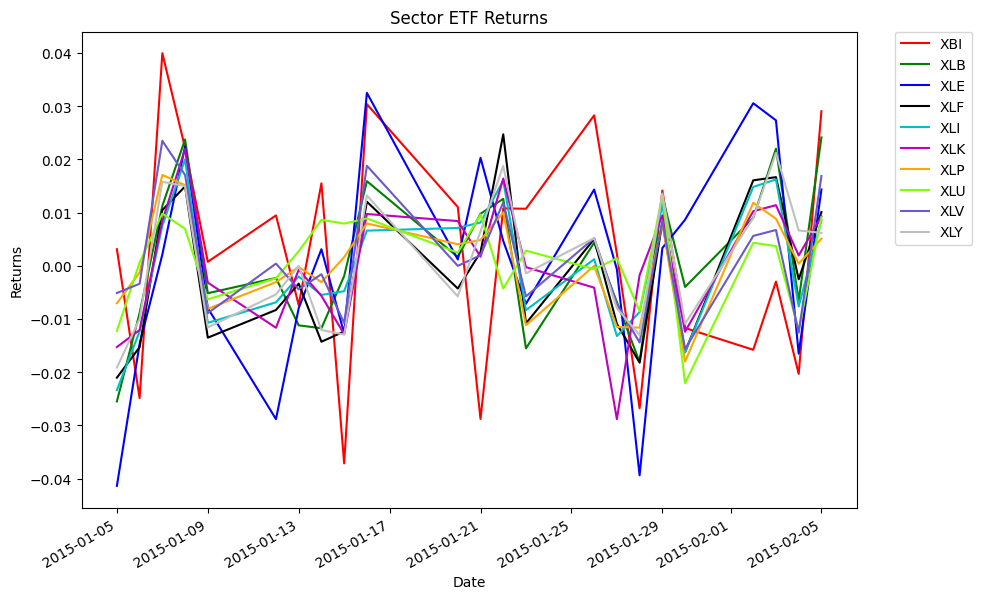

In [5]:
# Define a new time period for the portfolio example
portfolio_start = '2015-01-01'
portfolio_end = '2015-02-06'

# List of sector ETFs as proxies for a diversified set of stocks
assets = ['XLU', 'XLB', 'XLI', 'XLV', 'XLF', 'XLE', 'XLK', 'XLY', 'XLP', 'XBI']

# Fetch pricing data for the selected assets
data = get_pricing(assets, start_date=portfolio_start, end_date=portfolio_end)

# Calculate daily returns
returns = data.pct_change().dropna()

# Plot the returns
returns.plot(figsize=(10,7), color=['r', 'g', 'b', 'k', 'c', 'm', 'orange',
                                    'chartreuse', 'slateblue', 'silver'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylabel('Returns')
plt.title('Sector ETF Returns')
plt.show()


We hypothesize that the stocks which do well for the first week will regress after another month, while those which do poorly at first will appreciate in value.

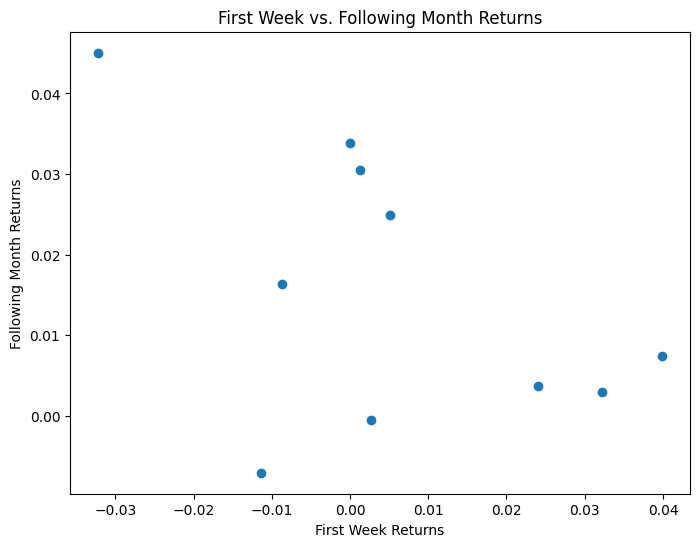

In [6]:
# Convert pricing data to a NumPy array for manipulation
data_np = data.values

# Calculate returns for the first week
wreturns = (data_np[4] - data_np[0]) / data_np[0]

# Rank securities by first week returns (0 being lowest)
order = wreturns.argsort()
ranks = order.argsort()

# TODO: Calculate returns for the following month
mreturns = 
raise NotImplementedError("This function needs to be implemented. Please modify the code.")
order2 = mreturns.argsort()
ranks2 = order2.argsort()

# Scatter plot to visualize potential anti-correlation
plt.figure(figsize=(8,6))
plt.scatter(wreturns, mreturns)
plt.xlabel('First Week Returns')
plt.ylabel('Following Month Returns')
plt.title('First Week vs. Following Month Returns')
plt.show()

The returns look like they could be anticorrelated, but what would have happened if we had followed the mean-reversion strategy when we examined the past week's returns?

In [7]:
# Identify long and short positions based on ranks

# TODO: Long the bottom 20% (here, bottom 2 out of 10)
longs =
raise NotImplementedError("This function needs to be implemented. Please modify the code.")
# TODO: Short the top 20% (top 2 out of 10)
shorts =
raise NotImplementedError("This function needs to be implemented. Please modify the code.")

# Display the selected long and short positions
long_positions = [assets[i] for i in range(len(assets)) if longs[i]]
short_positions = [assets[i] for i in range(len(assets)) if shorts[i]]

print('Going long in:', long_positions)
print('Going short in:', short_positions)

# Calculate the yield
# Assume we invest equally in each position and rebalance after the period
# Yield is the sum of (following month return * (longs - shorts))
yield_value = np.sum(mreturns * (longs - shorts))
print(f"Yield: {yield_value:.3f}")

Going long in: ['XLI', 'XLV']
Going short in: ['XLU', 'XLP']
Yield: 0.028


# Pairs trading

In pairs trading, the quantity we are examining is the distance between two securities, which we expect to revert back to its mean. For this to be a reasonable assumption, we need the two securities to be statistically <i>cointegrated</i>. In practice, two companies whose products are substitutes for each other are often cointegrated. That is, they generally move together due to shifts in the market and in their specific industry, and move little relative to each other.

How do we incorporate the prediction about their difference into our portfolio? Suppose we are looking at two securities X and Y. Then we go long in X and short in Y when the two are closer together than expected, and short in X and long in Y when the two are far apart. In this way we remain neutral to the market, industry, and other shifts that cause X and Y to move together, while making money on their difference reverting to the mean. We can quantify "closer than expected" as the difference having a z-score of less than -1, and "farther apart than expected" as a z-score greater than 1. This is easier to picture if X's price is higher than Y's, but the end result is the same in either case.

Using the `coint` function from `statsmodels`, let's check whether HP and Microsoft stock prices are cointegrated.

In [8]:
# Define the time period for pairs trading
pairs_start = '2012-01-01'
pairs_end = '2015-01-01'

# Load pricing data for Microsoft (MSFT) and HP (HPQ)
X = get_pricing('MSFT', fields='price', start_date=pairs_start, end_date=pairs_end)
Y = get_pricing('HPQ', fields='price', start_date=pairs_start, end_date=pairs_end)

# Ensure both series have the same length and aligned dates
data_pairs = pd.concat([X, Y], axis=1).dropna()
X = data_pairs['MSFT']
Y = data_pairs['HPQ']

# TODO: Compute the p-value for the cointegration of the two series
_, pvalue, _ =
raise NotImplementedError("This function needs to be implemented. Please modify the code.")
print(f"P-Value for Cointegration: {pvalue}")

P-Value for Cointegration: 0.01596334391985863


The p-value is low, so the two series are cointegrated. Next we need to find the mean of the difference. We'll compute the cumulative moving average - that is, the average of all the values up to each day - as though we were looking at the data every day without knowing the future.

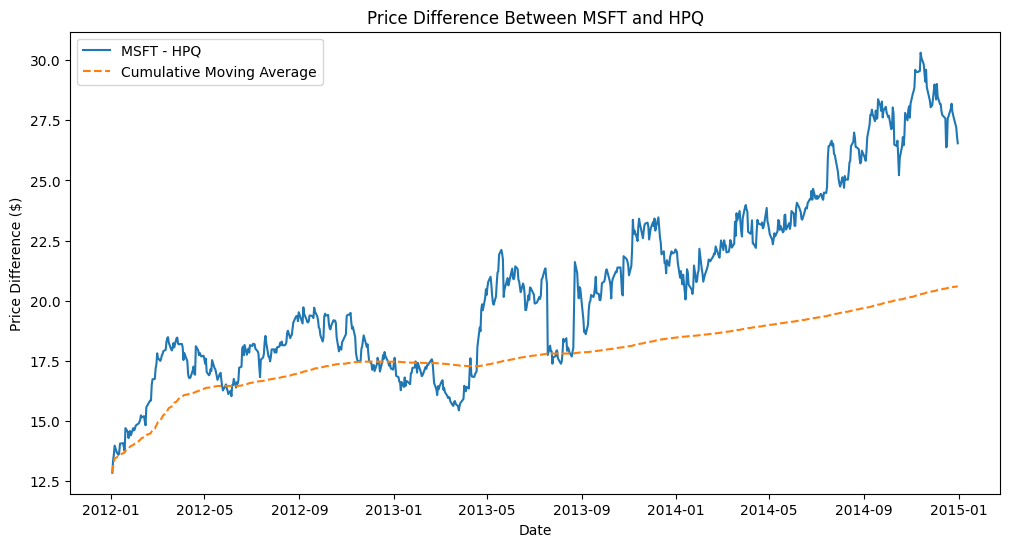

In [9]:
# Compute the difference between the two securities
diff = X - Y

# Compute the cumulative moving average of the difference
mu = diff.expanding().mean()

# Plot the difference and its cumulative moving average
plt.figure(figsize=(12,6))
plt.plot(diff, label='MSFT - HPQ')
plt.plot(mu, label='Cumulative Moving Average', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.title('Price Difference Between MSFT and HPQ')
plt.legend()
plt.show()


In some cases, we may instead want our mean to refer only to the moving average, excluding data from too long ago. Below we can see the difference between the cumulative moving average and the 60-day running average.

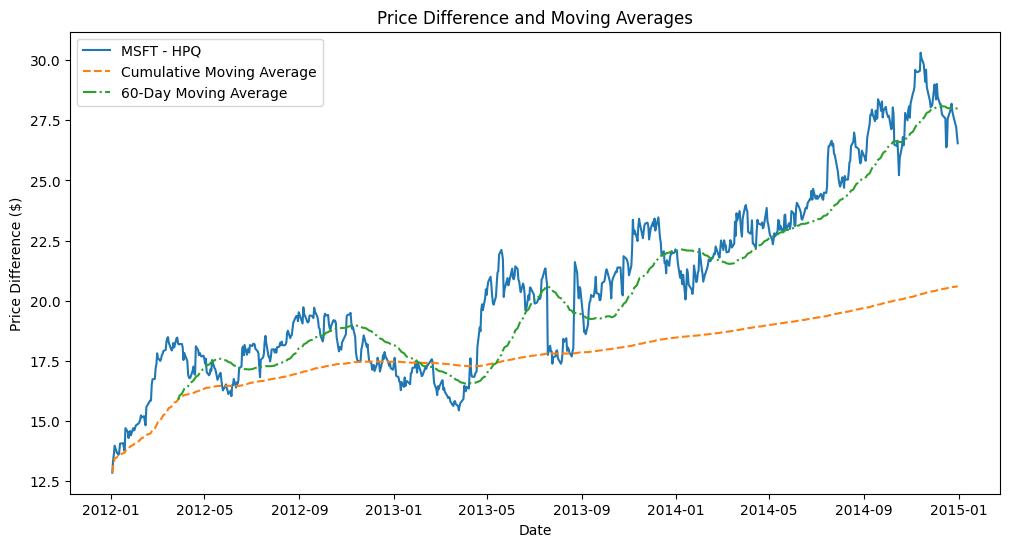

In [10]:
mu_60d = diff.rolling(window=60).mean()

plt.figure(figsize=(12,6))
plt.plot(diff, label='MSFT - HPQ')
plt.plot(mu, label='Cumulative Moving Average', linestyle='--')
plt.plot(mu_60d, label='60-Day Moving Average', linestyle='-.')
plt.xlabel('Date')
plt.ylabel('Price Difference ($)')
plt.title('Price Difference and Moving Averages')
plt.legend()
plt.show()

From here our trading strategy is identical to that for a single security, where we replace the asset with the spread X-Y. When we short the spread, we buy Y and sell X, and vice versa for going long. We'll be using the CMA for the mean, but you can easily change it to see the difference. Keep in mind, however, that what works well with this data may not be suited for other situations, and each definition of the mean will sometimes outperform the other.

In [11]:
# Compute the z-score of the difference on each day
zscores_pairs = (diff - mu) / diff.expanding().std()

# Initialize money and position count
money_pairs = 0
count_pairs = 0

# Iterate through each day to simulate pairs trading
for i in range(len(diff)):
    # Sell the spread if the z-score is > 1
    if zscores_pairs.iloc[i] > 1:
        money_pairs += diff.iloc[i]
        count_pairs -= 1
    # Buy the spread if the z-score is < -1
    elif zscores_pairs.iloc[i] < -1:
        money_pairs -= diff.iloc[i]
        count_pairs += 1
    # Clear positions if the z-score is between -0.5 and 0.5
    elif abs(zscores_pairs.iloc[i]) < 0.5:
        money_pairs += count_pairs * diff.iloc[i]
        count_pairs = 0

print(f"Final Money from Pairs Trading: ${money_pairs:.4f}")

Final Money from Pairs Trading: $8115.2317


For more details on this strategy, see the notebook and discussion [here](https://www.quantopian.com/posts/how-to-build-a-pairs-trading-strategy-on-quantopian).

# Alternative approaches

Mean-reversion strategies assume that trends tend to reverse direction. On the opposite end of the spectrum are trend-following or momentum-based strategies. These hypothesize that prices will, despite fluctuations, generally move in the direction they were moving in before. They can also take into account how quickly a price is moving, and anticipate changes in the direction of movement when it slows down. These are covered in more detail in another notebook.